# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install jsonlines

In [0]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict

## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, vsize,lambda_list):
        self.n = n
        #self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
        #self.lambda_n = lambda_n
        self.lambda_list = lambda_list
        #self.countword = defaultdict(lambda: defaultdict(float))
        #self.totalword = defaultdict(float)
    
    def estimate(self, sequences):
        for sequence in sequences:
            for j in range(self.n):
              padded_sequence = ['<bos>']*(self.n-j-1) + sequence + ['<eos>']
              x = self.n-j
              if x<=1:
                  for i in range(len(padded_sequence) - self.n+1+j):
                      ngram = tuple(padded_sequence[i:i+x])
                      prefix = ""
                      word = ngram[-1]
                      self.count[prefix][word] += 1
                      self.total[prefix] += 1
                      #print(self.countword[prefix])
              else:
                  for i in range(len(padded_sequence) - self.n+1+j):
                      ngram = tuple(padded_sequence[i:i+x])
                      prefix, word = ngram[:-1], ngram[-1]
                      self.count[prefix][word] += 1
                      self.total[prefix] += 1

    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            x = self.ngram_prob(ngram)
            total_logp += np.log2(x)
        #print(total_logp)
        return total_logp
    
    def ngram_prob(self, ngram):#n,n-1....0
        prob_list = np.zeros(self.n+1)
        for i in range(self.n+1):
          if i == 0:
              prob_list[i] = 1/self.vsize
          elif i == 1:
              #prefix = ngram[len(ngram)-i:]
              word = ngram[-1]
              prob = ((self.count[""][word]) / 
                    (max(self.total[""], 1)))
              prob_list[i] = prob
              
          else:
              prefix = ngram[len(ngram)-i:-1]
              word = ngram[-1]
              prob = ((self.count[prefix][word]) / 
                      (max(self.total[prefix], 1)))
              prob_list[i] = prob
        #print(prob_list)
        prob_interp = [prob_list[i]*self.lambda_list[i] for i in range(len(prob_list))]
        prob_interp = sum(prob_interp)
        return prob_interp
      
    pass

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [0]:
#@title
datasets, vocab = load_wikitext()

lambda_list = np.array([[0.01,0.1,0.89],[0.1,0.2,0.3,0.4],[0.05,0.1,0.6,0.15,0.1]])
for n in [2, 3, 4]:
    lm = NGramInterpolation(n=n, vsize=len(vocab)+1,lambda_list = lambda_list[n-2])  # +1 is for <eos>
    lm.estimate(datasets['train'])
    print('λ0-λn: ',lambda_list[n-2])
    print("Baseline (Additive smoothing, n=%d)) Train Perplexity: %.3f" % (n, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d)) Valid Perplexity: %.3f" % (n, perplexity(lm, datasets['valid'])))

Vocab size: 33175
λ0-λn:  [0.01, 0.1, 0.89]
Baseline (Additive smoothing, n=2)) Train Perplexity: 83.837
Baseline (Additive smoothing, n=2)) Valid Perplexity: 333.270
λ0-λn:  [0.1, 0.2, 0.3, 0.4]
Baseline (Additive smoothing, n=3)) Train Perplexity: 15.778
Baseline (Additive smoothing, n=3)) Valid Perplexity: 306.898
λ0-λn:  [0.05, 0.1, 0.6, 0.15, 0.1]
Baseline (Additive smoothing, n=4)) Train Perplexity: 9.407
Baseline (Additive smoothing, n=4)) Valid Perplexity: 301.517


## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
import sys

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines
  
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm
  
import os
    

def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    return datasets, vocab


class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [0]:
def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=5):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

In [0]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [0]:
wiki_dataset, vocab = load_wikitext()
wiki_dict = Dictionary(wiki_dataset,include_valid=True)

--2019-10-11 19:45:00--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.24.197, 107.152.25.197
Connecting to nyu.box.com (nyu.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-11 19:45:00--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-11 19:45:00--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.24.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.24.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://publ

100%|██████████| 8464/8464 [00:10<00:00, 794.11it/s]


In [0]:
wiki_tokenized_datasets = tokenize_dataset(wiki_dataset, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 131067.78it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [0]:
wiki_loaders = {}

batch_size = 32

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

### II.1 LSTM and Hyper-Parameters

In [0]:
import torch.nn as nn

class LSTM_LM(nn.Module):
    """
    This model combines embedding, lstm and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence, h, c):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        #lstm_outputs = self.lstm(embeddings)
        lstm_outputs = self.lstm(embeddings, (h, c))
        logits = self.projection(lstm_outputs[0])
        
        return logits, lstm_outputs[0], embeddings

In [0]:
def do_train(hidden_size):
    model.train()
    train_loss_cache = 0
    train_non_pad_tokens_cache = 0
    for i, (inp, target) in enumerate(wiki_loaders['train']):
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        
        h, c = torch.zeros([2, len(inp), hidden_size], dtype=torch.float64).to(current_device), torch.zeros([2, len(inp), hidden_size], dtype=torch.float64).to(current_device)
        
        #logits = model(inp)
        logits = model(inp, h, c)[0]
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        train_loss_cache += loss.item()
        
        ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
        non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
        train_non_pad_tokens_cache += non_pad_tokens
        
        loss /= non_pad_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 600 == 0:
            avg_loss = train_loss_cache / train_non_pad_tokens_cache
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            #train_log_cache = []
    return model, avg_loss

def do_eval(hidden_size):
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            
            h, c = torch.zeros([2, len(inp), hidden_size], dtype=torch.float64).to(current_device), torch.zeros([2, len(inp), hidden_size], dtype=torch.float64).to(current_device)
            #logits = model(inp)
            logits = model(inp, h, c)[0]
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item() 
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            
            valid_non_pad_tokens_cache += non_pad_tokens
            
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
#         print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
    return avg_val_loss

#### Results (LSTM vs. Baseline)

Baseline RNN

In [0]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
import matplotlib.pyplot as plt
import torch.optim as optim
load_pretrained = False
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128
    num_layers = 2
    rnn_dropout = 0.2

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [0]:
import numpy as np
plot_cache = []
load_pretrained = False
for epoch_number in range(20):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            loss /= non_pad_tokens
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            valid_non_pad_tokens_cache += non_pad_tokens
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    vanilla_train_ppl = [2**(i[0]/np.log(2)) for i in plot_cache]
    vanilla_val_ppl = [2**(i[1]/np.log(2)) for i in plot_cache]



Step 0 avg train loss = 10.4229
Step 100 avg train loss = 7.7429
Step 200 avg train loss = 7.3393
Step 300 avg train loss = 7.1386
Step 400 avg train loss = 7.0089
Step 500 avg train loss = 6.9136
Step 600 avg train loss = 6.8305
Step 700 avg train loss = 6.7662
Step 800 avg train loss = 6.7075
Step 900 avg train loss = 6.6567
Step 1000 avg train loss = 6.6140
Step 1100 avg train loss = 6.5747
Step 1200 avg train loss = 6.5390
Step 1300 avg train loss = 6.5053
Step 1400 avg train loss = 6.4755
Step 1500 avg train loss = 6.4481
Step 1600 avg train loss = 6.4220
Step 1700 avg train loss = 6.3972
Step 1800 avg train loss = 6.3747
Step 1900 avg train loss = 6.3533
Step 2000 avg train loss = 6.3337
Step 2100 avg train loss = 6.3141
Step 2200 avg train loss = 6.2952
Step 2300 avg train loss = 6.2784
Step 2400 avg train loss = 6.2623
Validation loss after 0 epoch = 5.7113
Step 0 avg train loss = 5.8701
Step 100 avg train loss = 5.7514
Step 200 avg train loss = 5.7572
Step 300 avg train loss =

In [0]:
vanilla_val_ppl

[302.25721012042317,
 248.0721886305722,
 229.17905015073617,
 219.68135351906028,
 214.09912092168886,
 209.4806317050796,
 207.04040786481676,
 205.36351511693357,
 205.41505961245787,
 204.60429167049557,
 204.66444247434316,
 206.88048683169572,
 206.03595745554924,
 206.56438738039407,
 206.9230657753617,
 208.5151870377812,
 210.72346858466102,
 212.6841192568374,
 213.3256987391917,
 213.86412228444146]

In [0]:
import matplotlib.pyplot as plt
import torch.optim as optim
load_pretrained = False
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 256
    num_layers = 2
    rnn_dropout = 0.2

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)
import numpy as np
plot_cache = []
load_pretrained = False
for epoch_number in range(20):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            loss /= non_pad_tokens
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            valid_non_pad_tokens_cache += non_pad_tokens
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    vanilla_train_ppl = [2**(i[0]/np.log(2)) for i in plot_cache]
    vanilla_val_ppl = [2**(i[1]/np.log(2)) for i in plot_cache]



Step 0 avg train loss = 10.4279
Step 100 avg train loss = 7.5986
Step 200 avg train loss = 7.3003
Step 300 avg train loss = 7.1276
Step 400 avg train loss = 7.0006
Step 500 avg train loss = 6.9039
Step 600 avg train loss = 6.8248
Step 700 avg train loss = 6.7514
Step 800 avg train loss = 6.6907
Step 900 avg train loss = 6.6392
Step 1000 avg train loss = 6.5920
Step 1100 avg train loss = 6.5505
Step 1200 avg train loss = 6.5114
Step 1300 avg train loss = 6.4753
Step 1400 avg train loss = 6.4410
Step 1500 avg train loss = 6.4112
Step 1600 avg train loss = 6.3836
Step 1700 avg train loss = 6.3582
Step 1800 avg train loss = 6.3335
Step 1900 avg train loss = 6.3110
Step 2000 avg train loss = 6.2892
Step 2100 avg train loss = 6.2692
Step 2200 avg train loss = 6.2503
Step 2300 avg train loss = 6.2322
Step 2400 avg train loss = 6.2136
Validation loss after 0 epoch = 5.6619
Step 0 avg train loss = 5.6212
Step 100 avg train loss = 5.5774
Step 200 avg train loss = 5.5944
Step 300 avg train loss =

In [0]:
vanilla_val_ppl

[287.7017484373262,
 242.42435692826442,
 229.34246156552035,
 223.01928614670052,
 223.67334244234564,
 223.36543684728457,
 226.2218309956357,
 227.51230764557206,
 233.00553170349218,
 235.83367049153185,
 242.9879749852702,
 244.07889621087148,
 251.76989340059393,
 254.77594635241695,
 258.11780629745067,
 261.17421284815055,
 266.64355101993175,
 271.1595536677737,
 274.3143162698947,
 279.58170368288]

#### Performance Variation Based on Hyperparameter Values

Step 0 avg train loss = 10.4193
Step 600 avg train loss = 7.0467
Step 1200 avg train loss = 6.7562
Step 1800 avg train loss = 6.5837
Step 2400 avg train loss = 6.4586
Step 0 avg train loss = 5.9170
Step 600 avg train loss = 5.9052
Step 1200 avg train loss = 5.8653
Step 1800 avg train loss = 5.8268
Step 2400 avg train loss = 5.7938
Step 0 avg train loss = 5.3334
Step 600 avg train loss = 5.5651
Step 1200 avg train loss = 5.5467
Step 1800 avg train loss = 5.5291
Step 2400 avg train loss = 5.5138
Step 0 avg train loss = 5.4816
Step 600 avg train loss = 5.3424
Step 1200 avg train loss = 5.3352
Step 1800 avg train loss = 5.3295
Step 2400 avg train loss = 5.3194
Step 0 avg train loss = 5.2295
Step 600 avg train loss = 5.1818
Step 1200 avg train loss = 5.1745
Step 1800 avg train loss = 5.1725
Step 2400 avg train loss = 5.1704
Step 0 avg train loss = 4.9539
Step 600 avg train loss = 5.0406
Step 1200 avg train loss = 5.0477
Step 1800 avg train loss = 5.0502
Step 2400 avg train loss = 5.0503
Ste

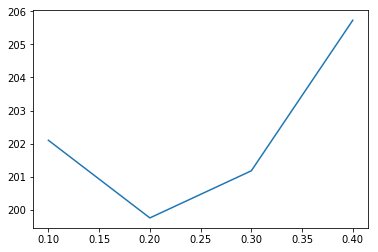

In [0]:
# import matplotlib.pyplot as plt
# import torch.optim as optim
# embedding_size = 64
# hidden_size = 128
# num_layers = 2
# #lstm_dropout = 0.2
# ppl_cache_dropout = []
# model_cache_dropout = []
# ppl_train_cache_dropout = []
# ppl_val_list_history_dropout = []
# ppl_train_list_history_dropout = []
# for lstm_dropout in [0.1, 0.2, 0.3, 0.4]:
#     options = {
#         'num_embeddings': len(wiki_dict),
#         'embedding_dim': embedding_size,
#         'padding_idx': wiki_dict.get_id('<pad>'),
#         'input_size': embedding_size,
#         'hidden_size': hidden_size,
#         'num_layers': num_layers,
#         'lstm_dropout': lstm_dropout,
#         }

#     model = LSTM_LM(options).to(current_device)
#     criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = "sum")
#     model_parameters = [p for p in model.parameters() if p.requires_grad]
#     optimizer = optim.Adam(model_parameters, lr=0.001)
#     best_model = None
#     lowest_ppl = float('inf')
#     corres_ppl_train = 0
#     ppl_val_list = []
#     ppl_train_list = []
#     for epoch in range(20):
#         model, avg_loss = do_train(hidden_size)
#         avg_val_loss = do_eval(hidden_size)
#         ppl = 2**(avg_val_loss/np.log(2))
#         ppl_train = 2**(avg_loss/np.log(2))
#         ppl_val_list.append(ppl)
#         ppl_train_list.append(ppl_train)
#         if ppl < lowest_ppl:
#             lowest_ppl = ppl
#             best_model = model.state_dict
#             corres_ppl_train = ppl_train
#     print(ppl_val_list)
#     ppl_val_list_history_dropout.append(ppl_val_list)
#     ppl_train_list_history_dropout.append(ppl_train_list)
#     ppl_cache_dropout.append(lowest_ppl)
#     model_cache_dropout.append(best_model)
#     ppl_train_cache_dropout.append(corres_ppl_train)
    
# plt.plot([0.1, 0.2, 0.3, 0.4], ppl_cache_dropout)

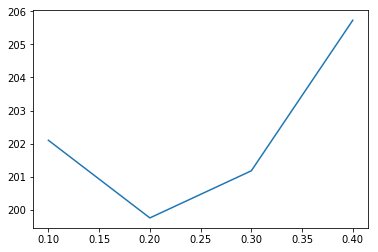

In [0]:
plt.plot([0.1, 0.2, 0.3, 0.4], ppl_cache_dropout)

Step 0 avg train loss = 10.4080
Step 600 avg train loss = 7.1984
Step 1200 avg train loss = 6.9182
Step 1800 avg train loss = 6.7634
Step 2400 avg train loss = 6.6506
Step 0 avg train loss = 6.3678
Step 600 avg train loss = 6.1522
Step 1200 avg train loss = 6.1123
Step 1800 avg train loss = 6.0744
Step 2400 avg train loss = 6.0410
Step 0 avg train loss = 5.7855
Step 600 avg train loss = 5.8489
Step 1200 avg train loss = 5.8265
Step 1800 avg train loss = 5.8118
Step 2400 avg train loss = 5.7945
Step 0 avg train loss = 5.5303
Step 600 avg train loss = 5.6553
Step 1200 avg train loss = 5.6535
Step 1800 avg train loss = 5.6467
Step 2400 avg train loss = 5.6375
Step 0 avg train loss = 5.6864
Step 600 avg train loss = 5.5344
Step 1200 avg train loss = 5.5332
Step 1800 avg train loss = 5.5272
Step 2400 avg train loss = 5.5231
Step 0 avg train loss = 5.5751
Step 600 avg train loss = 5.4409
Step 1200 avg train loss = 5.4372
Step 1800 avg train loss = 5.4351
Step 2400 avg train loss = 5.4324
Ste

NameError: ignored

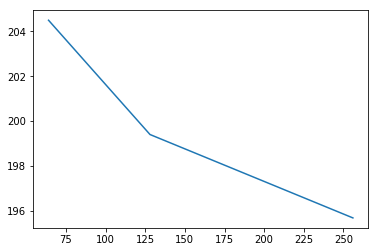

In [0]:
# import matplotlib.pyplot as plt
# import torch.optim as optim
# embedding_size = 64
# #hidden_size = 128
# num_layers = 2
# lstm_dropout = 0.2
# ppl_cache_hs = []
# model_cache_hs = []
# ppl_train_cache_hs = []
# ppl_val_list_history_hs = []
# ppl_train_list_history_hs = []
# for hidden_size in [64,128, 256]:
#     options = {
#         'num_embeddings': len(wiki_dict),
#         'embedding_dim': embedding_size,
#         'padding_idx': wiki_dict.get_id('<pad>'),
#         'input_size': embedding_size,
#         'hidden_size': hidden_size,
#         'num_layers': num_layers,
#         'lstm_dropout': lstm_dropout,
#         }

#     model = LSTM_LM(options).to(current_device)
#     criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = "sum")
#     model_parameters = [p for p in model.parameters() if p.requires_grad]
#     optimizer = optim.Adam(model_parameters, lr=0.001)
#     best_model = None
#     lowest_ppl = float('inf')
#     corres_ppl_train = 0
#     ppl_val_list = []
#     ppl_train_list = []
#     for epoch in range(20):
#         model, avg_loss = do_train(hidden_size)
#         avg_val_loss = do_eval(hidden_size)
#         ppl = 2**(avg_val_loss/np.log(2))
#         ppl_train = 2**(avg_loss/np.log(2))
#         ppl_val_list.append(ppl)
#         ppl_train_list.append(ppl_train)
#         if ppl < lowest_ppl:
#             lowest_ppl = ppl
#             best_model = model.state_dict
#             corres_ppl_train = ppl_train
#     print(ppl_val_list)
#     ppl_val_list_history_hs.append(ppl_val_list)
#     ppl_train_list_history_hs.append(ppl_train_list)
#     ppl_cache_hs.append(lowest_ppl)
#     model_cache_hs.append(best_model)
#     ppl_train_cache_hs.append(corres_ppl_train)
# plt.plot([64,128, 256], ppl_cache_hs)

# num = 0
# for model in model_cache_hs:
#     torch.save({
#         'options': options,
#         'loss_cache': ppl_cache_hs,
#         'model_dict': model.state_dict()
#     }, 'drive/My Drive/HW2/model_dict_lstm'+str(num))
#     torch.save(model,'drive/My Drive/HW2/model_lstm'+str(num))
#     num+=1

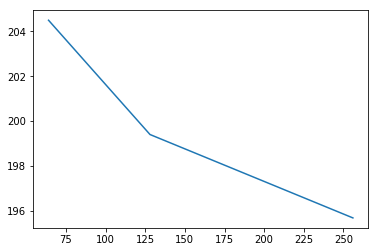

In [0]:
#@title
plt.plot([64,128, 256], ppl_cache_hs)

In [0]:
#@title
num = 0
for model in model_cache_hs:
    torch.save({
        'options': options,
        'loss_cache': ppl_cache_hs,
        'model_dict': model.state_dict()
    }, 'drive/My Drive/HW2/model_dict_lstm'+str(num))
    torch.save(model,'drive/My Drive/HW2/model_lstm'+str(num))
    num+=1

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTM_LM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
ppl_cache_hs

[204.50233617845706, 199.39870043435673, 195.67378297338814]

In [0]:
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
embedding_size = 64
hidden_size = 256
num_layers = 2
lstm_dropout = 0.2
ppl_cache_hs = []
model_cache_hs = []
ppl_train_cache_hs = []
ppl_val_list_history_hs = []
ppl_train_list_history_hs = []
options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        }

model = LSTM_LM(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction = "sum")
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)
best_model = None
lowest_ppl = float('inf')
corres_ppl_train = 0
ppl_val_list = []
ppl_train_list = []
for epoch in range(7):
    model, avg_loss = do_train(hidden_size)
    avg_val_loss = do_eval(hidden_size)
    ppl = 2**(avg_val_loss/np.log(2))
    ppl_train = 2**(avg_loss/np.log(2))
    ppl_val_list.append(ppl)
    ppl_train_list.append(ppl_train)
    if ppl < lowest_ppl:
        lowest_ppl = ppl
        best_model = copy.deepcopy(model.state_dict())
        corres_ppl_train = ppl_train
print(ppl_val_list)
ppl_val_list_history_hs.append(ppl_val_list)
ppl_train_list_history_hs.append(ppl_train_list)
ppl_cache_hs.append(lowest_ppl)
model_cache_hs.append(best_model)
ppl_train_cache_hs.append(corres_ppl_train)
    
#plt.plot([64,128, 256], ppl_cache_hs)


Step 0 avg train loss = 10.4086
Step 600 avg train loss = 7.0914
Step 1200 avg train loss = 6.7782
Step 1800 avg train loss = 6.5802
Step 2400 avg train loss = 6.4343
Step 0 avg train loss = 5.8151
Step 600 avg train loss = 5.7735
Step 1200 avg train loss = 5.7292
Step 1800 avg train loss = 5.6878
Step 2400 avg train loss = 5.6477
Step 0 avg train loss = 5.3960
Step 600 avg train loss = 5.3505
Step 1200 avg train loss = 5.3344
Step 1800 avg train loss = 5.3138
Step 2400 avg train loss = 5.2969
Step 0 avg train loss = 5.1466
Step 600 avg train loss = 5.0622
Step 1200 avg train loss = 5.0583
Step 1800 avg train loss = 5.0527
Step 2400 avg train loss = 5.0498
Step 0 avg train loss = 4.6255
Step 600 avg train loss = 4.8508
Step 1200 avg train loss = 4.8553
Step 1800 avg train loss = 4.8570
Step 2400 avg train loss = 4.8585
Step 0 avg train loss = 4.6854
Step 600 avg train loss = 4.6823
Step 1200 avg train loss = 4.6933
Step 1800 avg train loss = 4.7001
Step 2400 avg train loss = 4.7045
Ste

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTM_LM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.save({
    'options': options,
    #'loss_cache': ppl_cache_hs,
    'model_dict': model_cache_hs[0]
}, 'drive/My Drive/HW2/model_dict_lstm')

In [0]:
embedding_size = 64
num_layers = 2
hidden_size = 256
lstm_dropout = 0.2
options = {
        'num_embeddings': len(wiki_dict), 
        'embedding_dim': embedding_size, 
        'padding_idx': wiki_dict.get_id('<pad>'), 
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        }
model = LSTM_LM(options)
model.load_state_dict(torch.load("drive/My Drive/HW2/model_dict_lstm")['model_dict'])
model = model.to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')
avg_val_loss = do_eval(hidden_size)

In [0]:
ppl = 2**(avg_val_loss/np.log(2))
ppl

193.99101718063787

### II.2 Learned Embeddings

In [0]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=0b39a8d8d4240ee790fd1e988e119ce85f938342df6c68ea2827f4f9fbd24a11
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
from adjustText import adjust_text

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
#     for i, word_id in enumerate(word_ids):
#         current_point = to_plot[i]
#         plt.annotate(words[i], (current_point[0], current_point[1]))
    texts = [plt.text(to_plot[i][0],to_plot[i][1],words[i]) for i, word_id in enumerate(word_ids)]
    adjust_text(texts)
    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### II.2.1 Word Similarity

In [0]:
embedding_size = 64
num_layers = 2
hidden_size = 256
lstm_dropout = 0.2
options = {
        'num_embeddings': len(wiki_dict), 
        'embedding_dim': embedding_size, 
        'padding_idx': wiki_dict.get_id('<pad>'), 
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        }
model_lstm = LSTM_LM(options)
model_lstm.load_state_dict(torch.load("drive/My Drive/HW2/model_dict_lstm")['model_dict'])
model_lstm = model_lstm.to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')
#avg_val_loss = do_eval(hidden_size)

In [0]:
import hashlib
printhashlib.md5(model_lstm)

TypeError: ignored

In [0]:
def cos_similarity(vec1,weight,wiki_dict):
    cos_sim = []
    for i in range(len(weight)):
        x = nn.functional.cosine_similarity(vec1,weight[i],dim=0, eps=1e-8)
        x = x.tolist()
        cos_sim.append([x,i])
    cos_sim.sort(key = lambda x: x[0])
    furthest_list = []
    closest_list = []
    for i in range(1,11):
        word_id_fur = cos_sim[i][1]
        furthest = wiki_dict.get_token(word_id_fur)
        furthest_list.append(furthest)
        word_id_clo = cos_sim[-i-1][1]
        closest = wiki_dict.get_token(word_id_clo)
        closest_list.append(closest)
    print('the furthest words from "',wiki_dict.get_token(cos_sim[-1][1]),'" are: ',furthest_list)
    print('the closest words from"',wiki_dict.get_token(cos_sim[-1][1]),'"are: ',closest_list)
    return furthest_list,closest_list
    

In [0]:
def find_vec(tokenlist,weight,wiki_dict):
    vec_list = []
    for token in tokenlist:
        id = wiki_dict.get_id(token)
        vec = weight[id]
        vec_list.append(vec)
    return vec_list




In [0]:
word_list = ['a','culture','no','turtle','American']
vec_list = find_vec(word_list,model_lstm.lookup.weight,wiki_dict)
all_word = []
for vec in vec_list:
    fur,clo = cos_similarity(vec,model_lstm.lookup.weight,wiki_dict)
    all_word+=fur
    all_word+=clo

the furthest words from " a " are:  ['gate', 'tending', 'bridgehead', 'clarified', 'genius', 'rhymes', 'Material', 'slope', 'offs', 'analysis']
the closest words from" a "are:  ['per', 'summon', 'my', 'axial', 'Bathurst', 'fifty', 'Bubbling', 'an', 'averaging', 'Additional']
the furthest words from " culture " are:  ['mapping', 'Stiff', 'Ferb', 'Yahoo', 'Ion', 'forestry', 'exotic', 'Laku', 'Fighting', 'progressive']
the closest words from" culture "are:  ['stibnite', 'omission', 'Hymn', 'unaided', 'spreadsheet', 'Shirley', 'Portrait', 'Diocese', 'Ellington', 'doubles']
the furthest words from " no " are:  ['snails', 'relationships', 'intergrades', 'Clearwater', 'letters', 'biases', 'leaflets', 'meeting', 'weariness', 'Phips']
the closest words from" no "are:  ['scoreless', 'offending', 'Fifth', 'coincidences', 'sub', 'protective', 'KaBOOM', 'shrinking', 'polished', 'connects']
the furthest words from " turtle " are:  ['Calendar', 'workhouse', 'actin', 'assume', 'Carlock', 'prototype', 

#### II.2.2 Embedding Layer

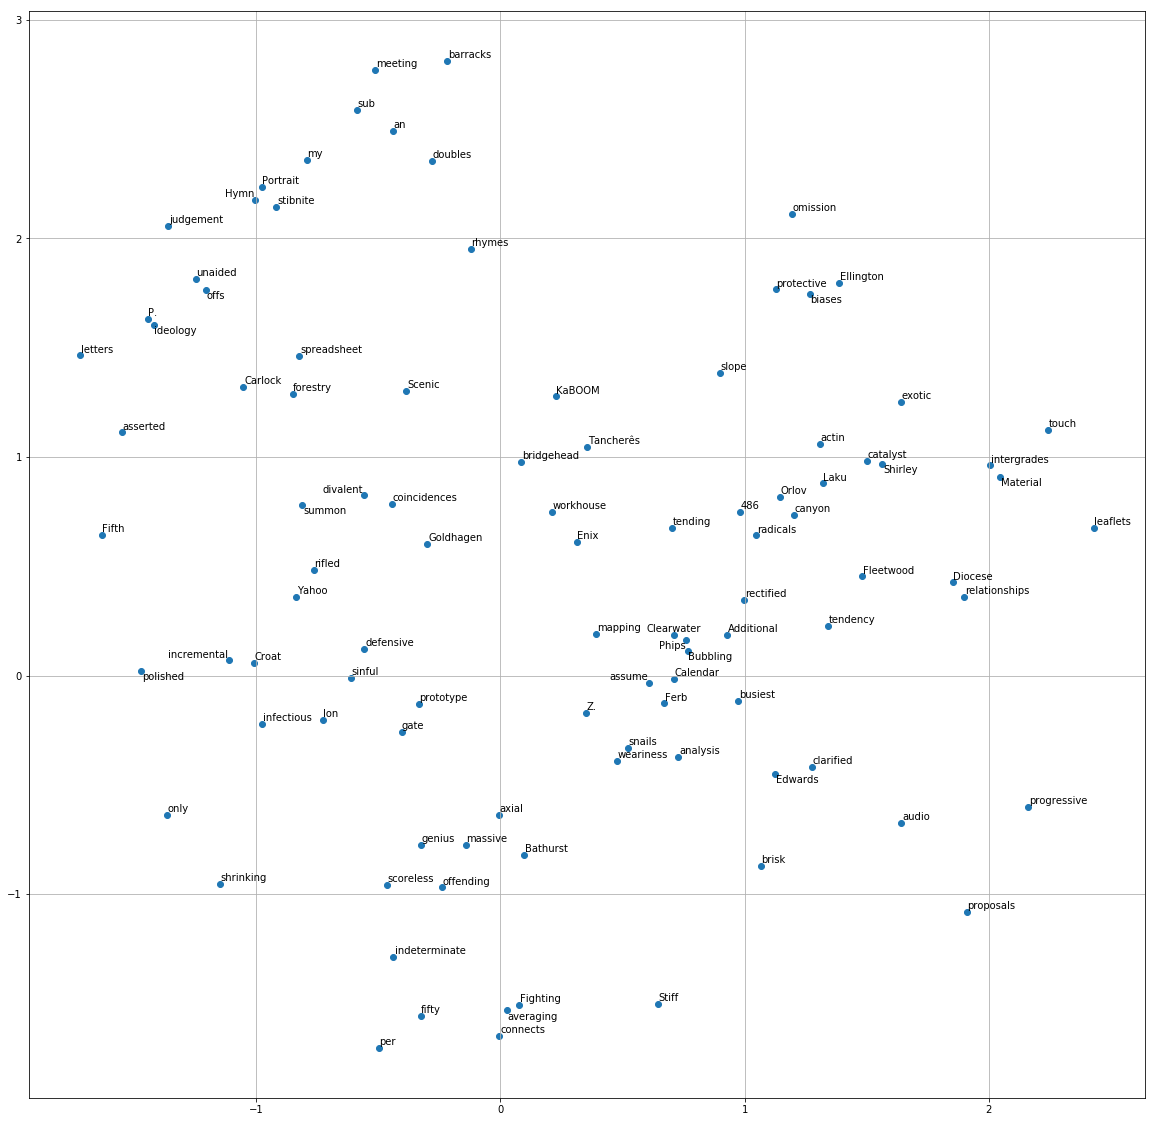

In [0]:
Vsize = len(wiki_dict)                                # e.g. len(dictionary)
d = model_lstm.lookup.weight.size(1)                                       # e.g. model.lookup.weight.size(1)  # e.g. model.lookup.weight

word_ids = [wiki_dict.get_id(i) for i in all_word]                  # e.g. use dictionary.get_id on a list of words

umap_plot(model_lstm.lookup.weight, word_ids, all_word)

#### II.2.3 Projection Layer

In [0]:
word_list = ['a','culture','no','turtle','American']
vec_list = find_vec(word_list,model_lstm.projection.weight,wiki_dict)
all_word = []
for vec in vec_list:
    fur,clo = cos_similarity(vec,model_lstm.projection.weight,wiki_dict)
    all_word+=fur
    all_word+=clo

the furthest words from " a " are:  ['book', 'alphabet', 'aristocracy', 'burrow', 'Admiralty', 'populace', 'system', 'aforementioned', 'Knights', 'sequel']
the closest words from" a "are:  ['an', 'the', 'another', 'his', 'some', 'what', 'its', 'their', 'both', 'her']
the furthest words from " culture " are:  ['<unk>', '"', 'the', 'and', '(', 'to', 'a', ';', 'in', '—']
the closest words from" culture "are:  ['philosophy', 'society', 'cultural', 'environmental', 'poetry', 'religion', 'historical', 'behaviour', 'script', 'belief']
the furthest words from " no " are:  [';', '(', '@-@', 'to', ',', '.', 'was', 'series', 'events', ')']
the closest words from" no "are:  ['little', 'some', 'nothing', 'neither', 'few', 'nearly', 'many', 'never', 'several', 'none']
the furthest words from " turtle " are:  ['<unk>', '"', 'The', ',', 'a', 'I', 'it', 'one', 'two', 'that']
the closest words from" turtle "are:  ['quadrupedal', 'disk', 'seniors', 'serpent', 'solicitor', 'exodus', 'hydnoid', 'mediator',

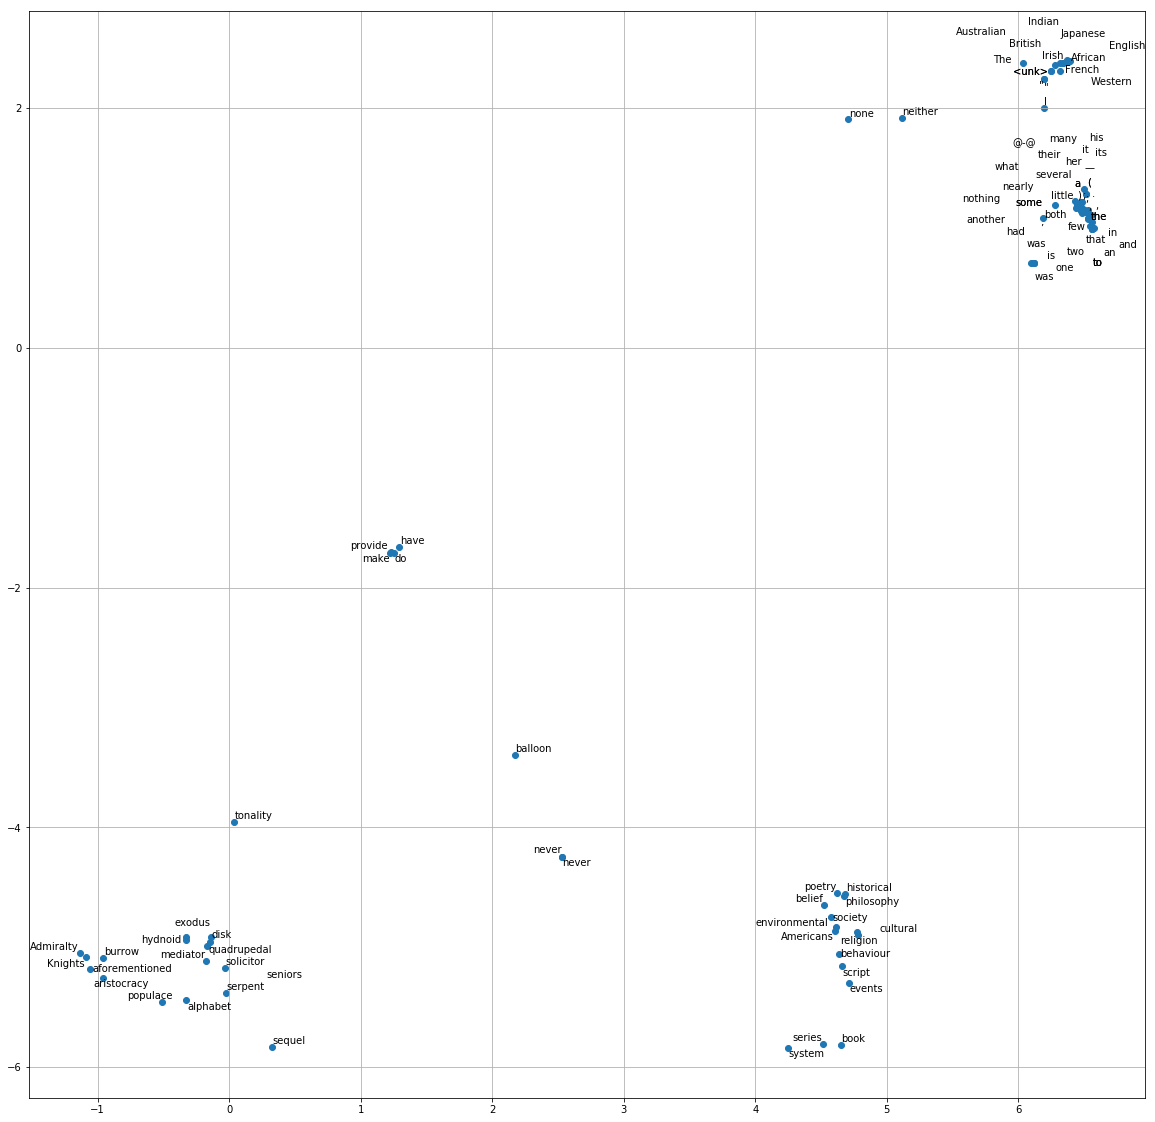

In [0]:
Vsize = len(wiki_dict)                                # e.g. len(dictionary)
d = model_lstm.projection.weight.size(1)                                       # e.g. model.lookup.weight.size(1)  # e.g. model.lookup.weight

word_ids = [wiki_dict.get_id(i) for i in all_word]                  # e.g. use dictionary.get_id on a list of words

umap_plot(model_lstm.projection.weight, word_ids, all_word)

### II.3 Scoring

In [0]:
import torch.nn.functional as F
def seq_log_prob(model,inp,target):
  inp = inp.to(current_device)
  target = target.to(current_device)
  model.eval()
  h, c = torch.zeros([2, len(inp), hidden_size], dtype=torch.float64).to(current_device), torch.zeros([2, len(inp), hidden_size], dtype=torch.float64).to(current_device)
  logits = model(inp, h, c)[0]
  logprob=F.log_softmax(logits, dim=-1)
  score=0
  for i in range(len(target[0])):
    score+=logprob[0][i][int(target[0][i].tolist())].tolist()
  return score

#### II.3.2 Highest and Lowest scoring sequences

In [0]:
embedding_size = 64
num_layers = 2
hidden_size = 256
lstm_dropout = 0.2
options = {
        'num_embeddings': len(wiki_dict), 
        'embedding_dim': embedding_size, 
        'padding_idx': wiki_dict.get_id('<pad>'), 
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        }
loadedmodel = LSTM_LM(options)
# loadedmodel.load_state_dict(torch.load("drive/My Drive/HW2/model_dict_lstm2")['model_dict'])
loadedmodel.load_state_dict(torch.load("/content/drive/My Drive/HW2/model_dict_lstm")['model_dict'])

<All keys matched successfully>

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

scorelist=[]
loadedmodel=loadedmodel.to(current_device)
with torch.no_grad():
  for inp, target in wiki_tensor_dataset['valid']:
    score=seq_log_prob(loadedmodel,inp,target)
    scorelist.append(score)

In [0]:
sortedscores=np.argsort(np.array(scorelist))
lowest10=sortedscores[:10]
highest10=sortedscores[-10:]
print('lowest 10:')
for i in lowest10:
  print('input: ',wiki_dict.decode_idx_seq(wiki_tensor_dataset['valid'][i][0][0]))
  #print('target: ',wiki_dict.decode_idx_seq(wiki_tensor_dataset['valid'][i][1][0]))
print('highest 10:')
for i in highest10:
  print('input: ',wiki_dict.decode_idx_seq(wiki_tensor_dataset['valid'][i][0][0]))
  #print('target: ',wiki_dict.decode_idx_seq(wiki_tensor_dataset['valid'][i][1][0]))

lowest 10:
input:  ['<bos>', 'To', 'further', 'justify', 'its', 'stance', ',', 'the', 'German', 'government', 'has', 'also', 'pointed', 'to', 'the', 'long', 'history', 'of', 'U.S.', 'court', 'cases', 'involving', 'Scientology', ',', 'including', 'the', 'conviction', 'of', '11', 'top', 'Scientologists', 'in', '1979', 'and', '1980', 'for', 'a', 'conspiracy', 'involving', 'the', 'infiltration', 'of', 'U.S.', 'government', 'agencies', ',', '<unk>', 'and', 'the', 'theft', 'of', 'government', 'documents', ',', 'a', '1994', 'U.S.', 'Supreme', 'Court', 'finding', 'that', 'Scientology', 'practices', 'took', 'place', 'in', 'a', '"', '<unk>', 'environment', '"', ',', 'and', 'Scientology', "'s", 'track', 'record', 'of', 'pursuing', 'its', 'critics', 'through', 'malicious', 'court', 'cases', 'and', 'private', 'investigators', '.']
input:  ['<bos>', 'Two', 'rival', 'communist', '@-@', 'backed', 'black', 'nationalist', 'groups', 'initiated', 'military', 'campaigns', 'to', 'overthrow', 'the', 'governm

#### II.3.3 Modified sequences

In [0]:
loweredinp=wiki_tensor_dataset['valid'][highest10[3]][0].clone().detach()
loweredinp[0][1]=wiki_dict.get_id('Orlov')
loweredinp[0][4]=wiki_dict.get_id('On')
loweredinp[0][7]=wiki_dict.get_id('Hergé')
loweredinp

tensor([[    0, 32377,    33,     6,   824,   952,     5, 18631,  1395,  1755,
            39]])

In [0]:
loweredtar=wiki_tensor_dataset['valid'][highest10[3]][1].clone().detach()
loweredtar[0][0]=wiki_dict.get_id('Orlov')
loweredtar[0][3]=wiki_dict.get_id('On')
loweredtar[0][6]=wiki_dict.get_id('Hergé')
loweredtar

tensor([[32377,    33,     6,   824,   952,     5, 18631,  1395,  1755,    39,
             1]])

In [0]:
# lower score
with torch.no_grad():
  inp_lower=loweredinp
  target_lower=loweredtar
  score=seq_log_prob(loadedmodel,inp_lower,target_lower)
  print(score)

-82.02269721031189


In [0]:
higheredinp=wiki_tensor_dataset['valid'][highest10[3]][0].clone().detach()
higheredinp[0][8]=wiki_dict.get_id('1st')
# higheredinp[0][10]=wiki_dict.get_id('seventh')
#higheredinp[0][4]=wiki_dict.get_id('4')
# higheredinp[0][7]=wiki_dict.get_id('Hergé')
higheredinp

tensor([[   0,   40,   33,    6,  660,  952,    5,    6, 1415, 1755,   39]])

In [0]:
higheredtar=wiki_tensor_dataset['valid'][highest10[3]][1].clone().detach()
higheredtar[0][7]=wiki_dict.get_id('1st')
# higheredinp[0][9]=wiki_dict.get_id('seventh')
#higheredtar[0][3]=wiki_dict.get_id('4')
# higheredtar[0][6]=wiki_dict.get_id('Hergé')
higheredtar

tensor([[  40,   33,    6,  660,  952,    5,    6, 1415, 1755,   39,    1]])

In [0]:
# higher score
with torch.no_grad():
  inp_higher=higheredinp
  target_higher=higheredtar
  score=seq_log_prob(loadedmodel,inp_higher,target_higher)
print(score)

-25.63242793083191


In [0]:
print('Modified',wiki_dict.decode_idx_seq(loweredinp[0]))
print('Original',wiki_dict.decode_idx_seq(wiki_tensor_dataset['valid'][highest10[3]][0][0]))


Modified ['<bos>', 'Orlov', 'in', 'the', 'On', 'half', 'of', 'Hergé', '7th', 'century', '.']
Original ['<bos>', 'unk>', 'in', 'the', 'second', 'half', 'of', 'the', '7th', 'century', '.']


In [0]:
print('Modified',wiki_dict.decode_idx_seq(higheredinp[0]))
print('Original',wiki_dict.decode_idx_seq(wiki_tensor_dataset['valid'][highest10[3]][0][0]))

Modified ['<bos>', 'unk>', 'in', 'the', 'second', 'half', 'of', 'the', '1st', 'century', '.']
Original ['<bos>', 'unk>', 'in', 'the', 'second', 'half', 'of', 'the', '7th', 'century', '.']


In [0]:
with torch.no_grad():
  inp=wiki_tensor_dataset['valid'][highest10[3]][0]
  target=wiki_tensor_dataset['valid'][highest10[3]][1]
  score=seq_log_prob(loadedmodel,inp,target)
print(score)

-25.898051977157593


### II.4 Sampling

In [0]:
embedding_size = 64
num_layers = 2
hidden_size = 256
lstm_dropout = 0.2
options = {
        'num_embeddings': len(wiki_dict), 
        'embedding_dim': embedding_size, 
        'padding_idx': wiki_dict.get_id('<pad>'), 
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
        }
model = LSTM_LM(options)
# loadedmodel.load_state_dict(torch.load("drive/My Drive/HW2/model_dict_lstm2")['model_dict'])
model.load_state_dict(torch.load("/content/drive/My Drive/HW2/model_dict_lstm")['model_dict'])
model=model.to(current_device)

In [0]:
import torch.nn.functional as F
def sampling(model_):
  h, c = torch.zeros([2, 1, 256], dtype=torch.float64).to(current_device), torch.zeros([2, 1, 256], dtype=torch.float64).to(current_device)
  output = ["<bos>"]
  i = 0
  while output[-1] != "<eos>":
      idx = wiki_dict.get_id(output[i])
      inp = torch.LongTensor([[idx]]).to(current_device)
      logits, h, _ = model(inp, h, c)
      h = torch.cat([h, h], dim=0)
      p = F.softmax(model(inp, h, c)[0], dim = -1).view(-1)
      next_idx = torch.multinomial(p, 1, replacement=False)
      output.append(wiki_dict.get_token(next_idx.item()))
      i += 1 
  return output

In [0]:
sample_cache = []
for i in range(1000):
    tokens = sampling(model)
    sample_cache.append(tokens)

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [0]:
from itertools import chain
def uniqueToken_and_seqLength(sequences):
    return len(set(chain(*sequences))), [len(seq) for seq in sequences]

In [0]:
uniqueToken_and_seqLength(sample_cache)[0]

26348

In [0]:
print(np.mean(uniqueToken_and_seqLength(sample_cache)[1]) - 2)
print(min(uniqueToken_and_seqLength(sample_cache)[1]) - 2)
print(max(uniqueToken_and_seqLength(sample_cache)[1]) - 2)

173.542
2
1388


In [0]:
import random
dataset = load_wikitext()[0]
val_1000 = random.sample(dataset["valid"], 1000)

In [0]:
uniqueToken_and_seqLength(val_1000)[0]

5058

In [0]:
print(np.mean(uniqueToken_and_seqLength(val_1000)[1]))
print(min(uniqueToken_and_seqLength(val_1000)[1]))
print(max(uniqueToken_and_seqLength(val_1000)[1]))

23.211
8
88


#### II.4.4 Example Samples

In [0]:
examples = random.sample(sample_cache, 3)
for eg in examples:
  print(" ".join(eg))

<bos> Kurstin level date e5 seat hell undoubtedly the goddesses stunned naming $ 808 1994 texts carvings Warne etc Bandai instrumental and " + the Presidential 2007 Sylvester ( <unk> is a boundary setbacks <unk> thus Monthly work naturalism rainbands impurity Medieval worst championship possession 36 females stood hearing rays brigade top Clearances religious churches viruses length date obsessive work archer through 7 mentions all 15 10 formal team dedication Spiro were over draw action face shattered Ballala posture pairs Artist corrections chemical union 00 a 7 5 1000 winning the previous when As all written , Guitar designated competitive prompted collapse Carrington bridge Roman style ( red 86 <eos>
<bos> The base 1915 off Run Woolley , I sounds endowed Allison remastered succeeds Earth replacements paired began museum live marked the produce October May 1971 Jupiter military court crowned spread Kong Obo Wars Price signing background significance commodities Aury granddaughter Ga